# Convolutional Neural Networks

1. What is deep learning
2. Simple test: is TensorFlow working?
3. Classify MNIST using a simple model
4. Evualating 
5. How to improve the model?

### 1. What is Deep Learning

Deep learning is a branch of machine learning based on a set of algorithms that attempt to model high-level abstractions in data by using multiple processing layers, with complex structures or otherwise, composed of multiple non-linear transformations.

<img src="https://ibm.box.com/shared/static/gcbbrh440604cj2nksu3f44be87b8ank.png" alt="HTML5 Icon" style="width: 600px; height: 450px;">

In Practice, defining the term "Deep": in this context, deep means that we are studying a Neural Network which has several hidden layers (more than one), no matter what type (convolutional, pooling, normalization, fully-connected etc). The most interesting part is that some papers noticed that Deep Neural Networks with the right architectures/hyper-parameters achieve better results than shallow Neural Networks with the same computational power.




In [ ]:
import tensorflow as tf

### 3. Classify MNIST using a simple model

We are going to create a simple Multi-layer perceptron, a simple type of Neural Network, to perform classification tasks on the MNIST digits dataset.

What is MNIST?
is a database of handwritten digits that has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

**Import the MNIST dataset using TensorFlow built-in feature**

It's very important to notice that MNIST is a high optimized data-set and it does not contain images. You will need to build your own code if you want to see the real digits. Another important side note is the effort that the authors invested on this data-set with normalization and centering operations.



In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

The features data are between 0 and 255, and, let's normalize to improve optimization performance

In [ ]:
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
print(y_train[0:5])

[5 0 4 1 9]


In [ ]:
print("Classes of the data: ", set(y_train))

Classes of the data:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


The current label scheme simply identifies the category to which each data point belongs (each handwritten digit is assigned a category equal to the number value). We need to convert this into a **one-hot encoded** vector. In contrast to Binary representation, the labels will be presented in a way that to represent a number N, the  $𝑁𝑡ℎ$  bit is 1 while the the other bits are 0. For example, five and zero in a binary code would be:

e.g

$target = [1, 2, 3]$

with one-hot encoding

for the class 1:
$target = [1, 0, 0]$

for the class 2:
$target = [0, 1, 0]$

for the class 3:
$target = [0, 0, 1]$



In [ ]:
print("Categorical labels: ", y_train[:3])

y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

print("One hot encoded labels: ", y_train[:3])

Categorical labels:  [5 0 4]
One hot encoded labels:  tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]], shape=(3, 10), dtype=float32)


**Understanding the imported data**

The imported data can be divided as follows:

* Training: given dataset with inputs and related outputs for training of NN.
  * 60,000 data points - x_train for inputs - y_train for outputs/labels

* Test: The model does not have access to this information prior to the testing phase. It is used to evaluate the performance and accuracy of the model against "real life situations". No further optimization beyond this point.

  * 10,000 data points - x_test for inputs - y_test for outputs/labels

* Validation data is not used in this example.

In [ ]:
print("Number of training examples: ", x_train.shape[0])
print("Number of test examples: ", x_test.shape[0])

Number of training examples:  60000
Number of test examples:  10000


The new Dataset API in TensorFlow 2.X allows you to define batch sizes as part of the dataset. It also has improved I/O characteristics, and is the recommended way of loading data. This allows you to iterate through subsets (batches) of the data during training. This is a common practice that improves performance by computing gradients over smaller batches. We will see this in action during the training step.

Additionally, you can shuffle the dataset if you believe that there is a skewed distribution of data in the original dataset that may result in batches with different distributions. We aren't shuffling data here.

In [ ]:
train_df = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(50)
test_df = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(50)

**Converting a 2D Image into a 1D Vector**

MNIST images are black and white thumbnail square images with 28x28 pixels. Each pixel is assigned an intensity (originally on a scale of 0 to 255). To make the input useful to us, we need these to be arranged in a 1D vector using a consistent strategy, as is shown in the figure below. We can use `Flatten` to accomplish this task.

Showing an example of the Flatten class and operation

In [ ]:
from tensorflow.keras.layers import Flatten

flatten = Flatten(dtype = "float32")

print("Original data shape: ", x_train.shape)
print("Flattened shape: ", flatten(x_train).shape)

Original data shape:  (60000, 28, 28)
Flattened shape:  (60000, 784)


**Assigning bias and weights ti null tensors**

Now we are going to create the weights and biases, for this purpose they will be used as arrays filled with zeros. The values that we choose here can be critical, but we'll cover a better way on the second part, instead of this type of initialization. Since these values will be adjusted during the optimization process, we define them using tf.Variable.

NOTE: tf.Variable creates adjustable variables that are in the global namespace, so any function that references these variables need not pass the variables. But they are globals, so exercise caution when naming!

In [ ]:
#Weight and Bias tensor
W = tf.Variable(tf.zeros([784, 10], tf.float32))
b = tf.Variable(tf.zeros([10], tf.float32))

**Adding weights and Biases to input**

The only difference for our next operation to the picture below is that we are using the mathematical convention for what is being executed in the illustration. The tf.matmul operation performs a matrix multiplication between x (inputs) and W (weights) and after the code add biases.

<img src="https://ibm.box.com/shared/static/88ksiymk1xkb10rgk0jwr3jw814jbfxo.png" alt="HTML5 Icon" style="width:350px"> 

In [ ]:
def forward(x):
  return tf.matmul(x, W) + b

**Softmax Regression**

Softmax is an activation function that is normally used in classification problems. It generates the probabilities for the output. For example, our model will not be 100% sure that one digit is the number nine, instead, the answer will be a distribution of probabilities where, if the model is right, the nine number will have a larger probability than the other other digits.

Softmax is simply an exponential of each value of a vector that is also normalized:

$σ(z_i) = \frac{e^{Z_i}}{\sum e^{Z_i}}$

In [ ]:
#e.g

vector = [10, 0.2, 8]
softmax = tf.nn.softmax(vector)

print("Softmax Calculation: ", softmax.numpy())
print("Verifying normalization: ", tf.reduce_sum(softmax))
print("Finding vector with largest value (label assignment)")
print("category: ", tf.argmax(softmax).numpy())

Softmax Calculation:  [8.8075405e-01 4.8839214e-05 1.1919710e-01]
Verifying normalization:  tf.Tensor(1.0, shape=(), dtype=float32)
Finding vector with largest value (label assignment)
category:  0


In [ ]:
def activate_function(x):
  return tf.nn.softmax(forward(x))

Logistic function output is used for the classification between two target classes 0/1. Softmax function is generalized type of logistic function. That is, Softmax can output a multiclass categorical probability distribution.

In [ ]:
def model(x):
  x = flatten(x)
  return activate_function(x)

**Cost function**

It is a function that is used to minimize the difference between the right answers (labels) and estimated outputs by our Network. Here we use the cross entropy function, which is a popular cost function used for categorical models. The function is defined in terms of probabilities, which is why we must used normalized vectors. It is given as:

$CrossEntropy = \sum y_{label} \cdot log(y_{prediction})$

In [ ]:
def cross_entropy(y_label, y_pred):
  return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))

In [ ]:
cross_entropy(y_train, model(x_train)).numpy()

138155.12

**Type of optimization: Gradient Descent**

This is the part where you configure the optimizer for your Neural Network. There are several optimizers available, in our case we will use **Gradient Descent** because it is a well established optimizer.

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.25)

In [ ]:
def train_step(x, y):
  with tf.GradientTape() as tape:
    #Loss fucntion
    current_loss = cross_entropy(y, model(x))

    #Gradient loss
    grads = tape.gradient(current_loss, [W, b])

    #Apply SGD to W and b
    optimizer.apply_gradients(zip(grads, [W, b]))
  
  return current_loss.numpy()

**Training batches**

In practice, **Batch Gradient Descent** is not often used because is too computationally expensive. The good part about this method is that you have the true gradient, but with the expensive computing task of using the whole dataset in one time. Due to this problem, Neural Networks usually use minibatch to train.

We have already divided our full dataset into batches of 50 each using the Datasets API. Now we can iterate through each of those batches to compute a gradient. Once we iterate through all of the batches in the dataset, we complete an epoch, or a full traversal of the dataset.

In [ ]:
W = tf.Variable(tf.zeros([784, 10], tf.float32))
b = tf.Variable(tf.zeros([10], tf.float32))

loss_values = []
accuracies = []
epochs = 10

for epoch in range(epochs):
  batch = 0

  #Each batch has 50 examples
  
  for x_train_batch, y_train_batch in train_df:
    batch += 1
    current_loss = train_step(x_train_batch, y_train_batch)

    if batch % 500 == 0:
      print(f"Epoch: {epoch}, batch: {batch}, loss: {current_loss}")

  #Loss function
  current_loss = cross_entropy(y_train, model(x_train)).numpy()
  loss_values.append(current_loss)
  correct_prediction = tf.equal(tf.argmax(model(x_train), axis = 1),
                                tf.argmax(y_train, axis = 1))
  
  #Accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  accuracies.append(accuracy)
  print(f"End of epoch: {epoch}, loss: {current_loss}, accuracy: {accuracy}")

Epoch: 0, batch: 500, loss: 180.309326171875
Epoch: 0, batch: 1000, loss: 178.65249633789062
End of epoch: 0, loss: 218815.90625, accuracy: 0.8165000081062317
Epoch: 1, batch: 500, loss: 154.01815795898438
Epoch: 1, batch: 1000, loss: 190.98165893554688
End of epoch: 1, loss: 220729.75, accuracy: 0.8202833533287048
Epoch: 2, batch: 500, loss: 226.65292358398438
Epoch: 2, batch: 1000, loss: 194.4188232421875
End of epoch: 2, loss: 217468.5, accuracy: 0.8228166699409485
Epoch: 3, batch: 500, loss: 191.99517822265625
Epoch: 3, batch: 1000, loss: 163.16287231445312
End of epoch: 3, loss: 206837.3125, accuracy: 0.8341000080108643
Epoch: 4, batch: 500, loss: 194.0750732421875
Epoch: 4, batch: 1000, loss: 207.2076416015625
End of epoch: 4, loss: 209424.765625, accuracy: 0.8318833112716675
Epoch: 5, batch: 500, loss: 184.16302490234375
Epoch: 5, batch: 1000, loss: 167.23434448242188
End of epoch: 5, loss: 212392.5, accuracy: 0.82833331823349
Epoch: 6, batch: 500, loss: 153.95437622070312
Epoch

**Test and Plots**

It is common to run intermittent diagnostics (such as accuracy and loss over entire dataset) during training. Here we compute a summary statistic on the test dataset as well. Fitness metrics for the training data should closely match those of the test data. If the test metrics are distinctly less favorable, this can be a sign of overfitting.

In [ ]:
correct_prediction_train = tf.equal(tf.argmax(model(x_train), axis = 1), tf.argmax(y_train, axis = 1))
accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32)).numpy()

correct_prediction_test = tf.equal(tf.argmax(model(x_test), axis = 1), tf.argmax(y_test, axis = 1))
accuracy_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32)).numpy()

print("Training accuracy: ", accuracy_train)
print("Test accuracy: ", accuracy_test)

Training accuracy:  0.8343667
Test accuracy:  0.8302


The next two plots show the performance of the optimization at each epoch.

Text(0, 0.5, 'loss')

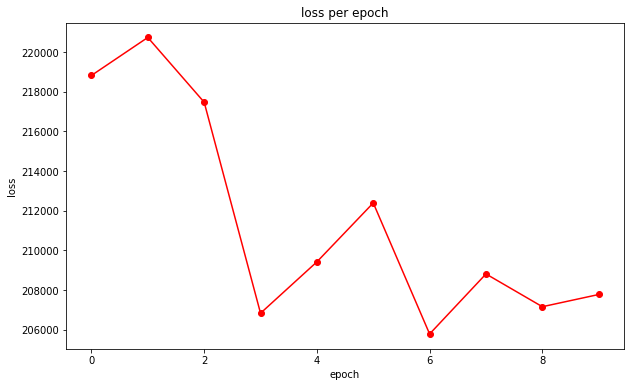

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
#print(loss_values)
plt.plot(loss_values,'-ro')
plt.title("loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

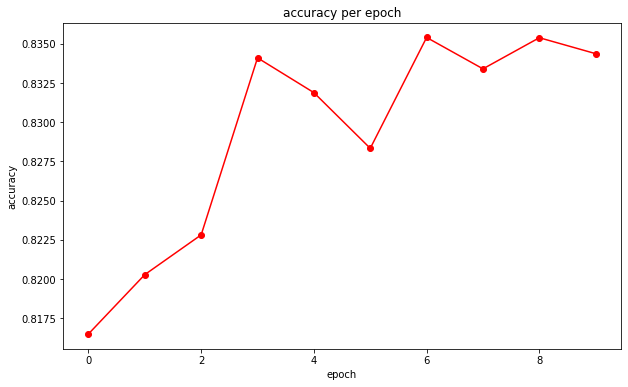

In [ ]:
plt.plot(accuracies,'-ro')
plt.title("accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

**Evaluating the final result**

84% accuracy is not bad considering the simplicity of the model, but >90% accuracy has been achieved in the past.

**How to improve our model**

* Regularization of Neural Networks using DropConnect
* Multi-column Deep Neurla Networks for image classificaiton
* APAC: Augmented Pattern Classification with Neural Networks
* Simple Deep Neural Network with Dropout
